In [ ]:
!pip install optuna shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.model_selection import cross_val_score
import shap

In [ ]:
df = pd.read_csv('credit_data.csv')

## EDA

In [ ]:
df.shape

(568630, 31)

In [ ]:
# checking if null values exist in all columns
df.isna().sum().sum()

0

In [ ]:
# check if theres duplicated column
df.duplicated().sum()

0

In [ ]:
df.Class.value_counts()

,count
Class,
0,284315
1,284315


In [ ]:
# checking the target class distribution
px.histogram(data_frame = df, x='Class', color='Class')

<function matplotlib.pyplot.show(close=None, block=None)>

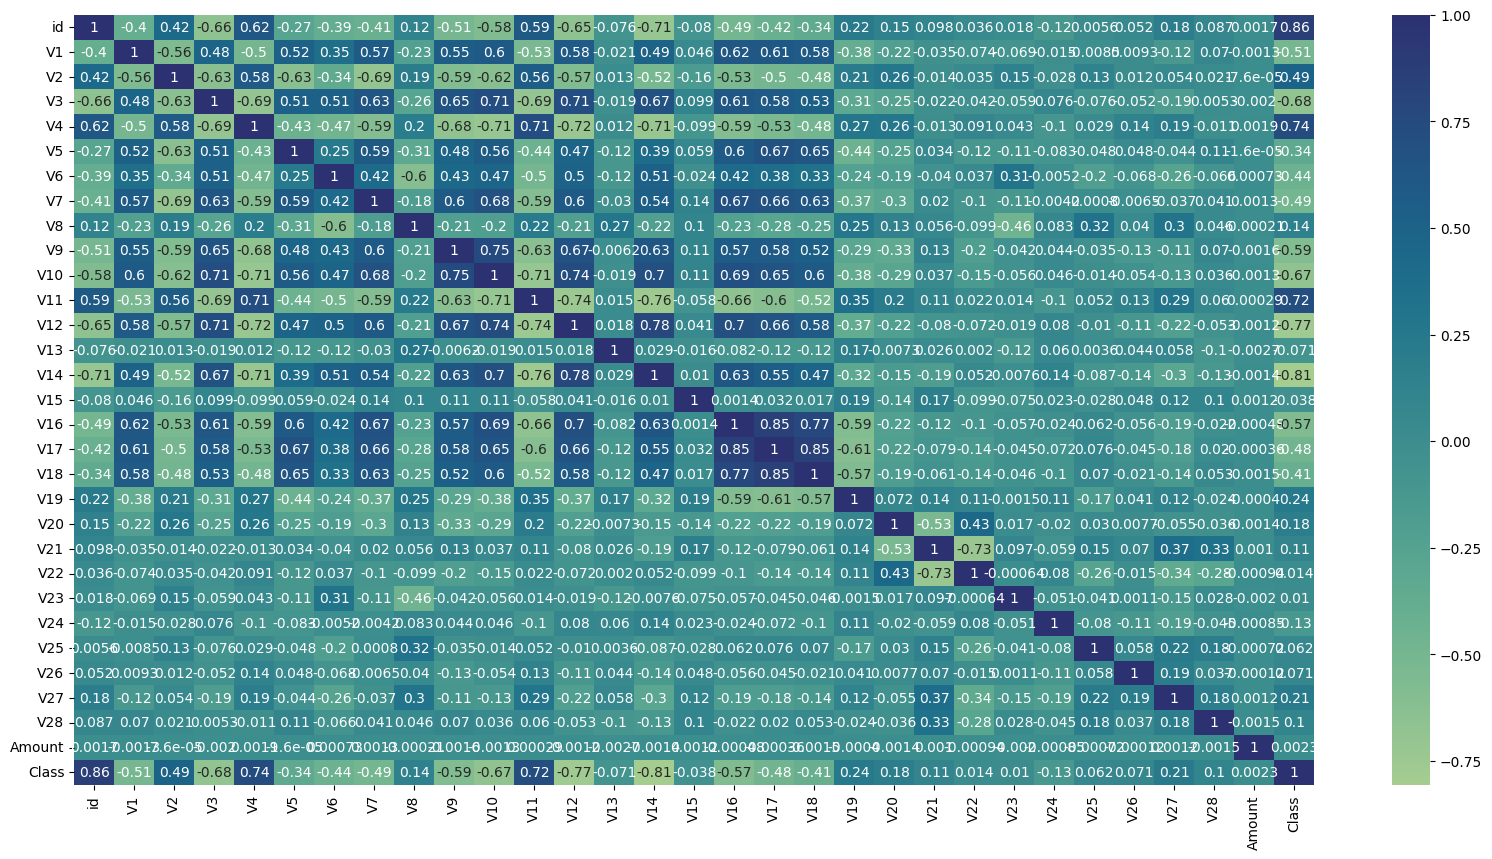

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(), cmap = 'crest', annot = True)
plt.show

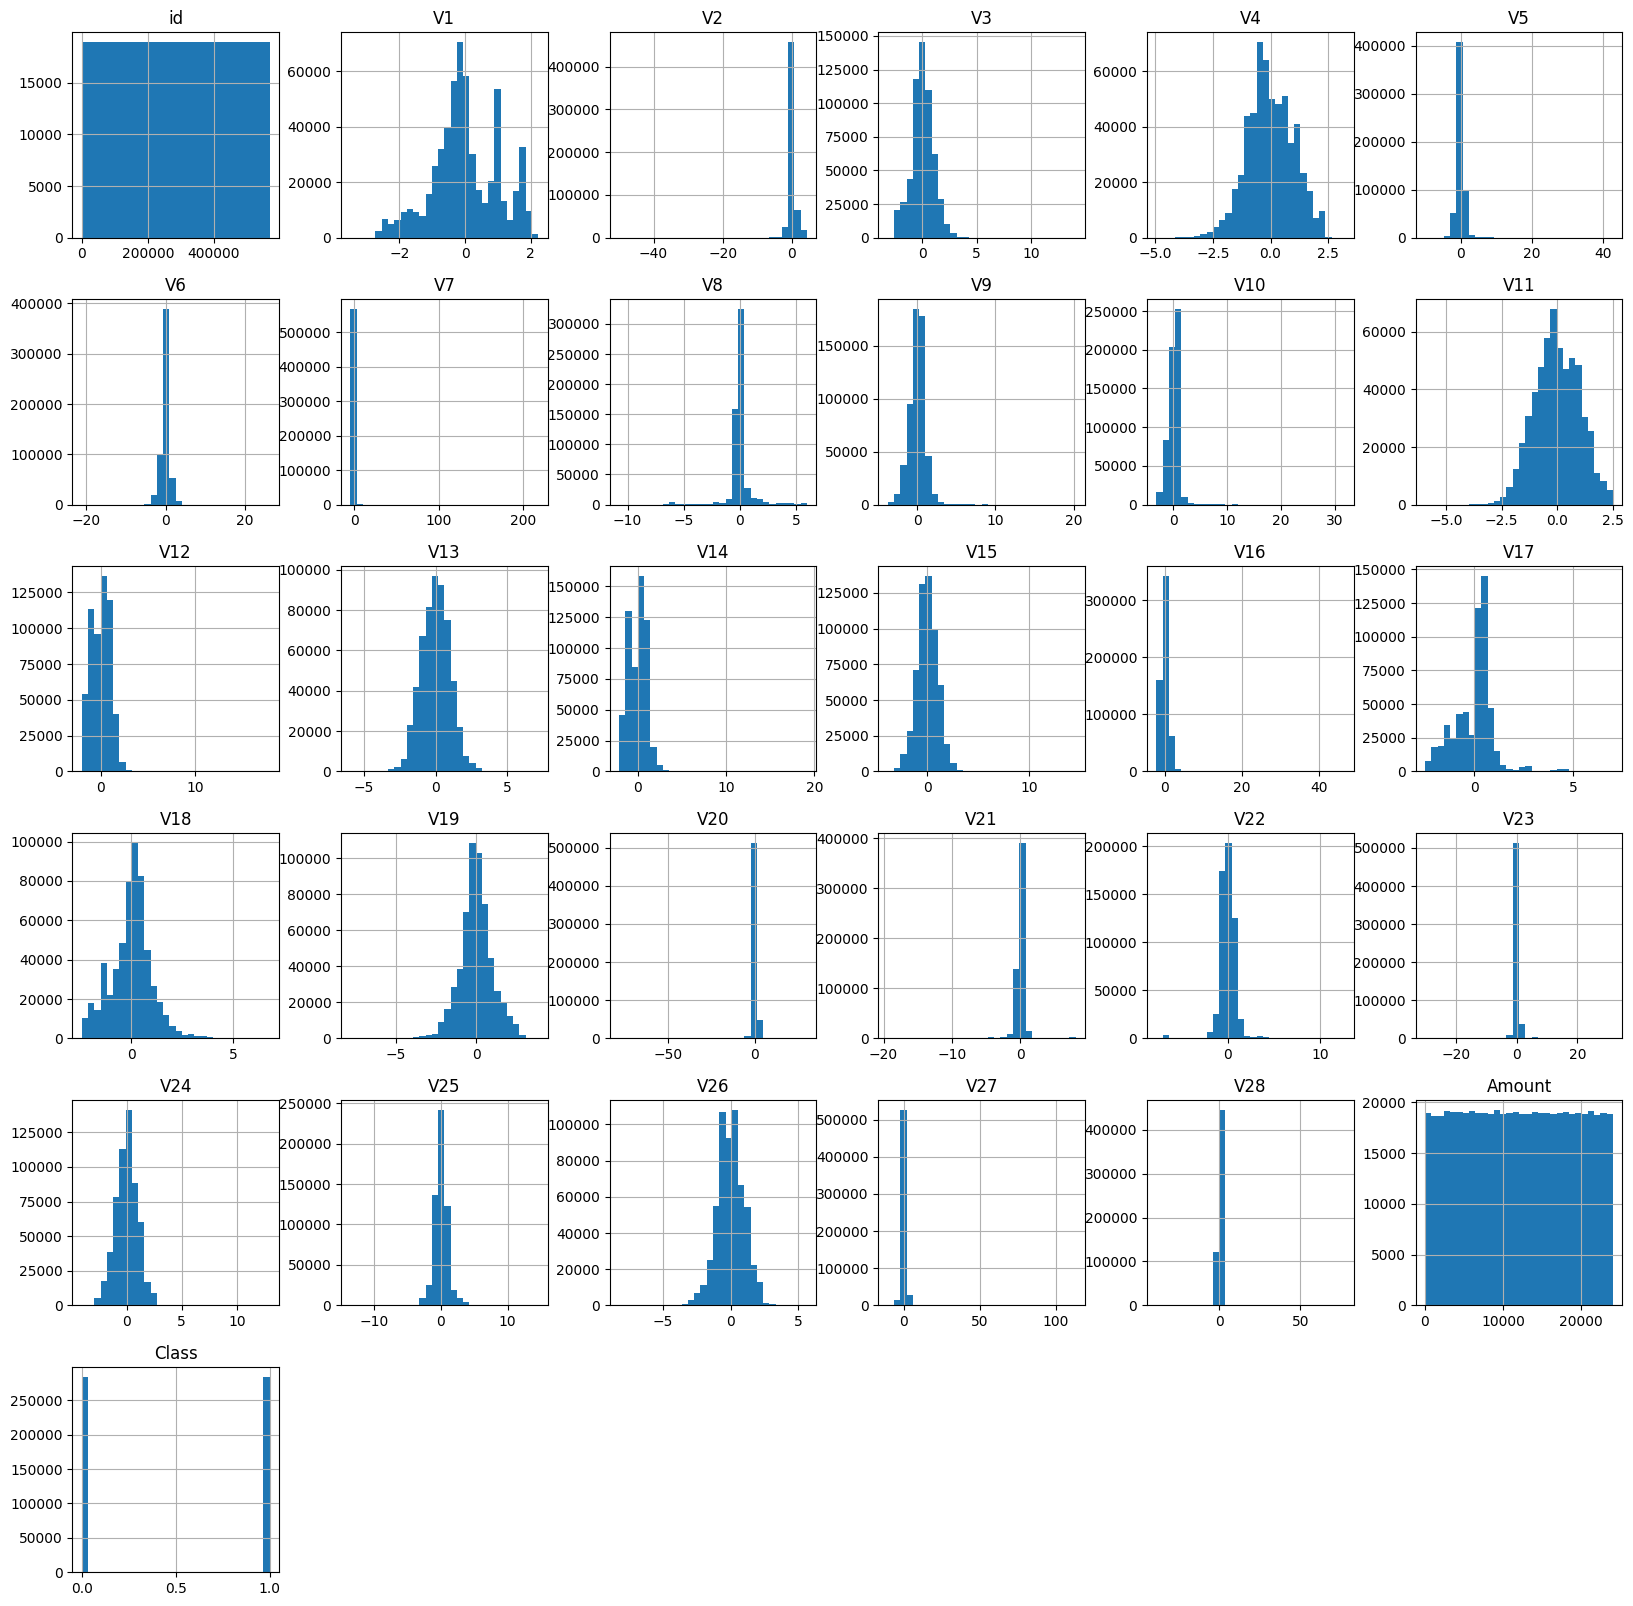

In [ ]:
df.hist(figsize=(20, 20), bins=30)
plt.show()

In [ ]:
df.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630.000000,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,284314.500000,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,...,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,12041.957635,0.5
std,164149.486122,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,0.000000,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,...,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,142157.250000,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,...,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,284314.500000,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,...,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,426471.750000,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,...,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000,1.0
max,568629.000000,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,...,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000,1.0


In [ ]:
# checking unique values for all column. all columns except Class in continuous variable. Class column is binary variable
unique_values_count = df.nunique()
print("Total unique values for each column:")
print(unique_values_count)

## Feature Engineering

In [ ]:
# splitting dataset
X = df.drop(['id', 'Class'], axis=1)
Y = df.Class

print(X.shape)
print(Y.shape)

(568630, 29)
(568630,)


In [ ]:
# Split into train (80%) and remaining (20%) first
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the remaining data into validation (10% of original) and test (10% of original)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(454904, 29)
(454904,)
(56863, 29)
(56863,)
(56863, 29)
(56863,)


StandardScaler is often the best default choice. It’s widely used across many machine learning tasks and works well in most scenarios.

Why StandardScaler?
Normalization: It standardizes features by removing the mean and scaling to unit variance. The data will have a mean of 0 and a standard deviation of 1.
Common Practice: It's a common preprocessing step for many algorithms, especially when the model assumes that the data is normally distributed (or close to it).
Flexibility: Works well with many types of data, even when the data is not perfectly normally distributed.

In [ ]:
scaler = StandardScaler()

# Step 2: Fit the scaler on x_train and transform x_train
x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)

## Model Definition

In [ ]:
logreg_model = LogisticRegression(max_iter=500)

In [ ]:
nb_model = GaussianNB()

In [ ]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, max_samples = 0.8, n_jobs=-1  )

## Model Training

### Logistic Regression

In [ ]:
logreg_model.fit(x_train, y_train)

LogisticRegression(max_iter=500)

In [ ]:
nb_model.fit(x_train, y_train)

GaussianNB()

### Random Forest Classifier

In [ ]:
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, max_samples=0.8, n_estimators=50,
                       n_jobs=-1)

## Model Evaluation

### Logistic Regression

In [ ]:
x_val_scaled = scaler.transform(x_val)
x_val_scaled = pd.DataFrame(x_val_scaled, columns=x_val.columns)

In [ ]:
# Print classification report for the training set
y_train_pred = logreg_model.predict(x_train_scaled)
print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred))

# Print classification report for the validation set
y_val_pred = logreg_model.predict(x_val_scaled)
print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    227565
           1       0.98      0.94      0.96    227339

    accuracy                           0.96    454904
   macro avg       0.96      0.96      0.96    454904
weighted avg       0.96      0.96      0.96    454904

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     28645
           1       0.98      0.94      0.96     28218

    accuracy                           0.96     56863
   macro avg       0.96      0.96      0.96     56863
weighted avg       0.96      0.96      0.96     56863



### Naive Bayes

In [ ]:
# Print classification report for the training set
y_train_pred = nb_model.predict(x_train_scaled)
print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred))

# Print classification report for the validation set
y_val_pred = nb_model.predict(x_val_scaled)
print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92    227565
           1       0.98      0.85      0.91    227339

    accuracy                           0.92    454904
   macro avg       0.92      0.92      0.92    454904
weighted avg       0.92      0.92      0.92    454904

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     28645
           1       0.98      0.85      0.91     28218

    accuracy                           0.92     56863
   macro avg       0.92      0.92      0.92     56863
weighted avg       0.92      0.92      0.92     56863



### Random Forest Classifier

In [ ]:
# Print classification report for the training set
y_train_pred = rf_model.predict(x_train_scaled)
print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred))

# Print classification report for the validation set
y_val_pred = rf_model.predict(x_val_scaled)
print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    227565
           1       1.00      0.97      0.98    227339

    accuracy                           0.98    454904
   macro avg       0.99      0.98      0.98    454904
weighted avg       0.99      0.98      0.98    454904

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     28645
           1       1.00      0.97      0.98     28218

    accuracy                           0.98     56863
   macro avg       0.98      0.98      0.98     56863
weighted avg       0.98      0.98      0.98     56863



### Model Selection and Hyperparameter tuning

In [ ]:
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    max_samples = trial.suggest_float('max_samples', 0.6, 0.8)

    # Create and train the XGBoost model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_samples=max_samples
    )
    model.fit(x_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(x_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

In [ ]:
# Create the Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-08-15 08:12:39,780] A new study created in memory with name: no-name-3fe6e210-6ea9-4320-a162-971143246fb7
[I 2024-08-15 08:16:18,295] Trial 0 finished with value: 0.98494627437877 and parameters: {'n_estimators': 53, 'max_depth': 10, 'max_samples': 0.7227919586256446}. Best is trial 0 with value: 0.98494627437877.
[I 2024-08-15 08:19:23,593] Trial 1 finished with value: 0.9668853208589065 and parameters: {'n_estimators': 67, 'max_depth': 7, 'max_samples': 0.714761218531547}. Best is trial 0 with value: 0.98494627437877.
[I 2024-08-15 08:22:52,653] Trial 2 finished with value: 0.9810949123331516 and parameters: {'n_estimators': 58, 'max_depth': 9, 'max_samples': 0.7739706477937249}. Best is trial 0 with value: 0.98494627437877.
[I 2024-08-15 08:25:55,893] Trial 3 finished with value: 0.9734625327541635 and parameters: {'n_estimators': 66, 'max_depth': 8, 'max_samples': 0.6084703320883542}. Best is trial 0 with value: 0.98494627437877.
[I 2024-08-15 08:28:10,141] Trial 4 finished

Best hyperparameters: {'n_estimators': 86, 'max_depth': 10, 'max_samples': 0.6307921058127297}
Best accuracy: 0.985421099836449


### Final Model Evaluation

In [ ]:
rf_model = RandomForestClassifier(n_estimators=86, max_depth=10, max_samples = 0.63, n_jobs=-1)
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, max_samples=0.63, n_estimators=86,
                       n_jobs=-1)

In [ ]:
x_test_scaled = scaler.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)

y_test_pred = rf_model.predict(x_test_scaled)

print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     28105
           1       1.00      0.97      0.99     28758

    accuracy                           0.99     56863
   macro avg       0.99      0.99      0.99     56863
weighted avg       0.99      0.99      0.99     56863



### Feature Importance

In [ ]:
# splitting dataset
x_train = df_sample.drop(['id', 'Class'], axis=1)
y_train = df_sample.Class

RandomForestClassifier(max_depth=10, max_samples=0.8, n_estimators=50,
                       n_jobs=-1)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, max_samples = 1, n_jobs=-1  )
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, max_samples=1, n_estimators=50, n_jobs=-1)

In [ ]:
y_train_pred = rf_model.predict(x_train)
print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred))

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        54
           1       0.00      0.00      0.00        46

    accuracy                           0.54       100
   macro avg       0.27      0.50      0.35       100
weighted avg       0.29      0.54      0.38       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



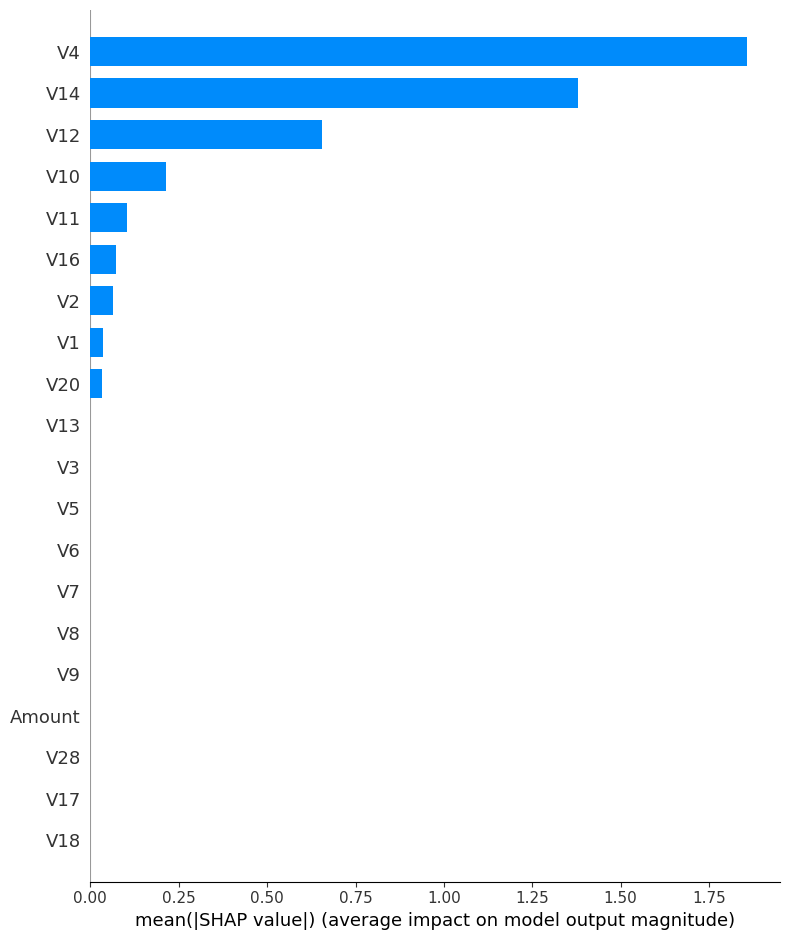

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train, y_train)

explainer = shap.TreeExplainer(xgb_model, x_train)
shap_values = explainer(x_train)

shap.summary_plot(shap_values, x_train, plot_type="bar")

(100, 29, 2)


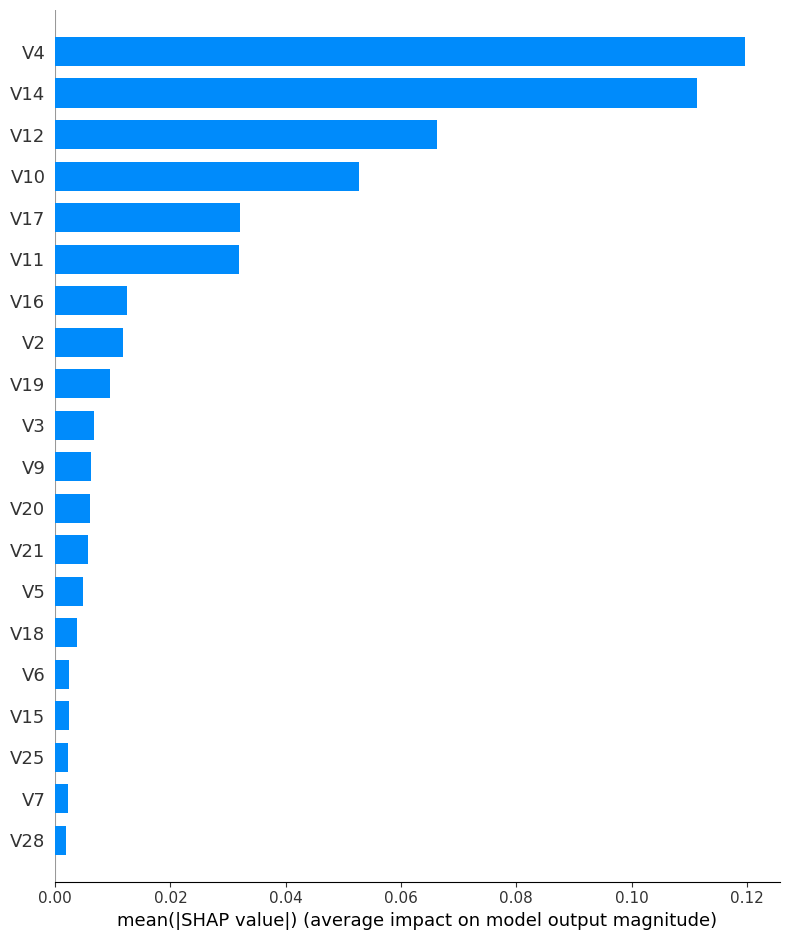

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

# Use TreeExplainer for RandomForestClassifier
explainer = shap.TreeExplainer(rf_model, x_train)
shap_values = explainer(x_train)

# Print the shape of shap_values to understand the structure
print(shap_values.values.shape)  # (n_samples, n_features, n_classes)

# Aggregate SHAP values across classes by taking the mean of absolute values across the last axis
shap_values_agg = np.mean(np.abs(shap_values.values), axis=2)

# Use the aggregated SHAP values to plot the feature importance
shap.summary_plot(shap_values_agg, x_train, plot_type="bar")

## Summary

### 1. **Project Overview**
   The objective of this project was to develop a machine learning model capable of flagging fraudulent activities effectively. The dataset used consisted of approximately 560,000 samples with 29 anonymized features and two class labels. Notably, the dataset exhibited no class imbalance, which is often a significant challenge in fraud detection tasks. To achieve the project’s objective, three baseline models were initially developed: Logistic Regression, Naive Bayes, and Random Forest.

### 2. **Key Findings**
   Among the models tested, Random Forest emerged as the best-performing model. The initial performance of the Random Forest model on the validation set showed high precision and recall for both classes, with an F1 score of 0.98. To further enhance the model’s performance, Bayesian optimization was employed for hyperparameter tuning, resulting in improved performance metrics on the test set, with F1 scores of 0.99 for both classes.

   In addition to performance evaluation, SHAP (SHapley Additive exPlanations) was used to determine feature importance. The analysis revealed that features `v4` and `v14` had the highest importance with SHAP values of 0.12, followed by `v12` and `v10` with SHAP values above 0.06. Other significant features included `v17` and `v11`, both with SHAP values of 0.04, while the remaining features contributed less to the model’s predictions, with SHAP values below 0.04.

### 3. **Conclusion**
   The project successfully developed a robust model for flagging fraud, with the Random Forest model demonstrating exceptional performance after hyperparameter tuning. The model achieved high precision and recall across both classes, underscoring its effectiveness in identifying fraudulent activities. The SHAP analysis provided valuable insights into the features driving the model’s decisions, highlighting the importance of certain features (`v4`, `v14`, `v12`, and `v10`) in predicting fraud.

   However, despite the model’s strong performance, it is essential to consider the trade-off between accuracy and interpretability. While the Random Forest model is highly accurate, its complexity may hinder transparency. Therefore, in applications where interpretability is crucial, simpler models like Logistic Regression might be preferred despite their lower accuracy.

   **Limitations** of this study include the anonymized nature of the features, which restricts the ability to draw domain-specific insights from the feature importance analysis. Additionally, the model’s performance should be validated on real-world data to ensure its generalizability.

   **Recommendations** for future work include exploring additional models, such as Gradient Boosting Machines or Neural Networks, to compare their performance with the tuned Random Forest. Additionally, integrating more domain-specific data or features could further enhance the model's predictive power.

### 4. **Final Thoughts**
   The results of this project have significant implications for fraud detection systems, particularly in industries where preventing fraud is critical. The next steps involve deploying the model in a real-world setting and continuously monitoring its performance to ensure its effectiveness in dynamic environments. Future research could also focus on improving model interpretability without sacrificing accuracy, ensuring that the model’s decisions can be easily understood and trusted by stakeholders.
